<a href="https://colab.research.google.com/github/inforeqd512/QLearning/blob/main/RL_TicTacToe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [790]:
import numpy as np
import pylab as plt

# Game

Every simulation starts with a new Game _Board_. 

Each iteration of the simulation ends when the board is full or when any of the players wins.

Every Player _Agent_ is setup with their _Policy Trainer_ and follows espilon greedy policy to learn best actions over several iterations of the simulation.

**measure of success** : The Players become good at playing when the 'Draw' percentages are high.. ie. the first player to go learns to play in the middle or lears to play to Draw

It takes approximately 5000 iterations to get to optimal q-values. At that time both players learn the game well enough to win approx 50% of the time. 

### Actors in the Game


_Board_ is the environment. _State_ is the position of the board after a move from any player. Board also provides the possible set of actions. These are set of open positions on the board on which the player can put it's symbol. 

_Agent_ is the player playing the game. 

- Player playing $X$ will be denoted by symbol $1$
- Player playing $O$ will be denoted by symbol $-1$

Every _Agent_ has its own _Policy Trainer_ that learns the best action it should do in the _Board_ environment. 

The _Policy_Trainer_ follows is the epsilon greedy random policy to choose the next action. Based on this policy it learns the _Quality Action or Q-table_ for each player. Typically the Q-values of Player X are different to those of Player O. 

The _Policy_Trainer_ also needs to update the Q-values after performing the action and seeing the reward, so the _Agent_ delegates the choosing of the action and the performing of the action to it. 


_Action_ to be performed is chosen by the agent on the current state of the board. It is the next available position on the board that the agent can choose from. 

        


### Exploration and Exploitation

Initially we explore more as we learn about the possible moves that can be made. Over multiple iterations we start exploiting what we've learnt so we decay the exploration factor epsilon. 

**Decaying epsilon-greedy**: Does the same as epsilon-greedy, however, the epsilon value starts out near 1, and decays over time according to γ to power of x where x represents the iteration the agent is in.  For γ 0.99 is used 

<sup>Source: [The Effect of the Exploration
Strategy on an Agent’s Performance](https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp,%20T._BSc_Thesis_2017.pdf?sequence=1) from Thijs Nieuwdorp</sup>

### Quality of Action 

**Q (dict)** - 

- key = state hash, 
- value = is an array representing 9 spaces in the tic tac toe grid,

Starting from top row of grid, from left to right then next row from left to right etc, based on the grid position sent as input action, the array index is computed
      
eg 
- for 0,1 grid position = 0 * 3 (number of rows and cols in grid) + 1 == 1 so the index of 1.. ie at position 2 in the array
- for 1,1 grid position = 1 * 3 + 1 == 4 so 0,1,2,3,4th position in the array 

beware!!! when using the default initialisation of parameter as {} then python allocates the same memory to both instances of PolicyTrainer. As a result both policies showed the same scores. Also showed win for 1 when should show only for -1.. The best way to find this happening is to initialise the game state to a board where only one player can win, but you'll see that both players get a non-zero Q-value


# Board

In [791]:
class Board:
  """ Class that represents the game board of Tic Tac Toe """

  playerX = 1
  playerO = -1

  def __init__(self, rows=3, cols=3):
    self.rows = rows
    self.cols = cols 
    self.resetGame()

  def resetGame(self):
    """ resets the state of the board when needed eg, start of a simulation and after one of the players has won """
    self.state = np.zeros((self.rows, self.cols), dtype=np.int8)
    # use below to test logic for one single win and change the learning rate to 1 to make equations simpler to test
    # self.state = np.array(
    #               [[ -1,  1,  0],
    #               [-1,  1, -1],
    #               [ 1, -1,  1]])
    self.state = np.array(
                  [[ 0,  0,  -1],
                  [0,  1, -1],
                  [ 0, 0,  0]])
  def checkWinner(self):
    """  return winner symbol, if one exists. 0 if no winner"""

    symbols = np.unique(self.state) #unique values , 0, 1, -1
    symbols = symbols[np.nonzero(symbols)] #remove 0's
    winning_symbol = 0 #no winner yet

    for symbol in symbols:
      #check rows
      row = np.any(np.all(self.state == symbol, axis=1))

      #check cols
      col = np.any(np.all(self.state == symbol, axis=0))

      #check diagonals
      diag1 = np.array([self.state[0,0], self.state[1,1], self.state[2,2]])
      diag1 = np.all(diag1 == symbol)

      diag2 = np.array([self.state[2,0], self.state[1,1], self.state[0,2]])
      diag2 = np.all(diag2 == symbol)

      # Check if state has winner and return winner in that case
      if row or col or diag1 or diag2:
        winning_symbol = symbol
        break
  
    return winning_symbol

  def getAvailablePos(self):
    """  Get state positions that have no value ie zeros """
    return np.argwhere(self.state == 0)

  def checkGameEnded(self):
    """ Check if game has ended by observing if there any possible moves left
    or there is a winner """
    ended = (len(self.getAvailablePos()) == 0) or (self.checkWinner() != 0)
    return ended

  def setPosition(self, x, y, symbol):
    """  Set state at position (x,y) with symbol """
    self.state[x,y] = symbol

  def getStateHash(self):
    """  Get hash key of state """
    return np.array2string(self.state)
  
  def performAction(self, action_to_perform, symbol):
    """  Perform the action on current board """
    self.setPosition(action_to_perform[0], action_to_perform[1], symbol)
    return self
      

In [792]:
class Agent:
  """ Class that represents the player 
      symbol is 1 for 'X' or -1 for 'O' 
      policy_trainer is initialised with epsilon greedy set to exploration_probability which is reduced overtime"""

  def __init__(self, symbol, exploration_probability):
    self.symbol = symbol
    self.policy_trainer = PolicyTrainer(exploration_probability=exploration_probability, symbol=symbol)
    return

  def performActionPerPolicy(self, state_hash, possible_actions, current_state):
    """ per the explore and exploitation with current epsilon """
    action = self.policy_trainer.chooseAction(state_hash, possible_actions)
    self.policy_trainer.performAction(current_state, action)

  def epsilonDecayPerIterations(self, num_iterations):
    """ gradually reduces probabilities per iteration but not completely eliminate it"""
    # Reduce probability to explore during training
    # Do not remove completely 
    
    # Decaying epsilon-greedy: Does the same as epsilon-greedy, however, the epsilon value starts out near 1,
    # and decays over time according to γ to power of x where x represents the iteration the agent is in. 
    # For γ 0.99 is used per https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp,%20T._BSc_Thesis_2017.pdf?sequence=1
        
    if self.policy_trainer.exploration_probability > 0.2:
      decay = 0.99 ** num_iterations
      self.policy_trainer.exploration_probability = decay

  def updateScore(self):
    """ measures how much is the q-values changing over iterations till finally they settle """
    self.policy_trainer.updateScore()


In [793]:
class PolicyTrainer:
  """
      exploration_probability (float) epsilon greedy value
      learning_rate (float)
      discount_factor (float)
      Q (dict) - {state_hash : array of grid positions}
  """
  def __init__(self, symbol, exploration_probability, learning_rate = 0.1, discount_factor = 0.9, grid_size = 3):
    self.Q = {} #beware!!! when using the initiatlisation value a {} then python allocates the same one to both policies
    self.learning_rate = 1.0 #learning_rate
    self.discount_factor = discount_factor
    self.exploration_probability = exploration_probability
    self.grid_size = grid_size
    self.scores = []
    self.symbol = symbol
    self.num_times_states_seen = {}
    return

  def getActionIndex(self, current_action):
    """ Returns index in the action array position where the q value should be put """
    idx = self.grid_size * current_action[0] + current_action[1]
    return idx

  def getValueQ(self, current_state_hash, current_action):
    """ Get the quality value of a given action in a given state,
            returns 0 if the state-action pair has not been seen before.
            Input is state hash key
            and action as an array of position where the symbol should be put ie [0,1] for top row middle square"""
    idx = self.getActionIndex(current_action)
    q_value = 0 
    if current_state_hash in self.Q:
      q_value = self.Q[current_state_hash][idx]

    return q_value

  def setValueQ(self, current_state_hash, current_action, value):
    """ Set value in Q 
    if this is the first time the state is seen, then the value is the array representing the grid"""
    idx = self.getActionIndex(current_action)
    if current_state_hash in self.Q:
      self.Q[current_state_hash][idx] = value
    else:
      self.Q[current_state_hash] = np.zeros(self.grid_size * self.grid_size)
      self.Q[current_state_hash][idx] = value
    return

  def rewardFunction(self, current_state_hash, next_state):
    """ when the chosen action is performed on a state, then we get a new state
    and associated reward from this transition is computed here
    if next state is winner then reward is 1 else 0 """
    winner = next_state.checkWinner()
    reward = 0 
    if winner == self.symbol:
      reward = 1
    
    # if reward == 1:
    # if self.symbol == 1:
    #   print("***rewardFunction")
    #   print("current_state_hash :  \n", current_state_hash)
    #   print("next state hash :  \n", next_state.getStateHash())
    #   print("symbol :  ", self.symbol)
    #   print("reward :  ", reward)

    return reward

  def chooseAction(self, state_hash, possible_actions):
    """ choose action per epsilon greedy explore/exploit policy """
    #Explore
    if random.random() < 0.2: #self.exploration_probability:
      action = self.chooseRandomAction(possible_actions)
    else:
      #Exploit
      action = self.chooseBestAction(state_hash, possible_actions)
    return action

  def chooseRandomAction(self, possible_actions):
    """ choose random action from list of possible actions in a state """
    random_idx = np.random.choice(possible_actions.shape[0])
    action_pos = possible_actions[random_idx]
    return action_pos

  def chooseBestAction(self, current_state_hash, possible_actions):
    """ Get best action given a set of possible actions in a given state """
    # Pick a random action at first
    random_idx = np.random.choice(possible_actions.shape[0])
    best_action = possible_actions[random_idx]

    # Find action that given largest Q in given state
    maxQ = 0 
    for action in possible_actions:
      tmpQ = self.getValueQ(current_state_hash, action)
      if maxQ < tmpQ:
        maxQ = tmpQ
        best_action = action

    return best_action

  def getMaxQ(self, next_state):
    """ go through all possible actions in a state 
    and pick the one with the highest quality value """
    actions = next_state.getAvailablePos()
    state_hash = next_state.getStateHash()

    # Find action that given largest Q in given state
    maxQ = 0 
    for action in actions:
      tmpQ = self.getValueQ(state_hash, action)
      if maxQ < tmpQ:
        maxQ = tmpQ

    return maxQ

  def performAction(self, current_state, current_action):
    """ Implements Q-learning iterative algorithm 
    we use a high learning_rate to give more value to the immediate reward so that we can see the values settle within 5000 iterations
    """
    current_state_hash = current_state.getStateHash()

    # Get current Q Value
    currentQ = self.getValueQ(current_state_hash, current_action)

    next_state = current_state.performAction(current_action, self.symbol)

    newQ = (1 - self.learning_rate) * currentQ
    newQ += self.learning_rate * (self.rewardFunction(current_state_hash, next_state) + self.discount_factor * self.getMaxQ(next_state))
    self.setValueQ(current_state_hash, current_action, newQ)

    if current_state_hash in self.num_times_states_seen:
      arr = self.num_times_states_seen[current_state_hash]
      if np.any(arr == current_action):
        #do nothing
        1
      else:
        arr.append(current_action)
        self.num_times_states_seen[current_state_hash] = list1
    else:
      self.num_times_states_seen[current_state_hash] = [current_action]

    # if self.symbol == 1:
    #   print("current_action :", current_action, "newQ : ", newQ)
      # print("\nperformAction\n", "\nsymbol :\n", self.symbol, "\ncurrentQ :\n", currentQ, "\ncurrent_state_hash :\n", current_state_hash, "\ncurrent_action :\n", current_action, "\nnewQ :\n", newQ)

  def updateScore(self):
    #compute score
    score = 0
    list1 = list(self.Q.values())
    score = np.sum(list1)
    self.scores.append(score)


# Q-Learning : Training

In [794]:
from tqdm import tqdm
import random

In [795]:
def simulate(iterations):
  """ iterations (int) """

  # Construct game board
  game = Board()

 # Epsilon-greedy 
  exploration_probability = 1.0

  # Initiatlise players
  playerX = Agent(Board.playerX, exploration_probability)
  playerO = Agent(Board.playerO, exploration_probability)

  # Counters for wins of each agent and total number of games
  nbr_wins_playerX = 0
  nbr_wins_playerO = 0
  nbr_games = 0

  # Pick current player
  current_player = playerX

  for i in tqdm(range(iterations)):

    # play full games in each iteration
    while not game.checkGameEnded():
      possible_actions = game.getAvailablePos()
      state_hash = game.getStateHash()
         
      current_player.performActionPerPolicy(state_hash, possible_actions, game)

      # Check if there is a winner
      winner = game.checkWinner() # Returns 0 if there is no winner
      if winner != 0: #winner is when it's 1 or -1
        if winner == playerX.symbol:
            nbr_wins_playerX += 1
        else:
            nbr_wins_playerO += 1

      # Swap player
      if current_player == playerX:
          current_player = playerO
      else:
          current_player = playerX

    #when the full game is finished or there is a winner, then reset game and increment and print metrics
    nbr_games += 1
    playerX.updateScore()
    playerO.updateScore()
    playerX.epsilonDecayPerIterations(nbr_games)
    playerO.epsilonDecayPerIterations(nbr_games)
    
    game.resetGame()

  # Print outcome
  print("\n\nWins: Agent X : ", nbr_wins_playerX, "Wins: Agent O : ", nbr_wins_playerO, "Total Games : ", nbr_games)    
  print("\nWin percentage: Agent X {:.2%}, Agent O {:.2%}.".format(nbr_wins_playerX/nbr_games, nbr_wins_playerO/nbr_games))
  print("\nDraw percentage: {:.2%} ".format((nbr_games - nbr_wins_playerX - nbr_wins_playerO)/nbr_games))

  return (playerX, playerO)



# Q-Learning : Training

In [796]:
(playerX, playerO) = simulate(5000)

100%|██████████| 5000/5000 [00:09<00:00, 505.45it/s]



Wins: Agent X :  663 Wins: Agent O :  4252 Total Games :  5000

Win percentage: Agent X 13.26%, Agent O 85.04%.

Draw percentage: 1.70% 


### How the episodes settle the Q-values

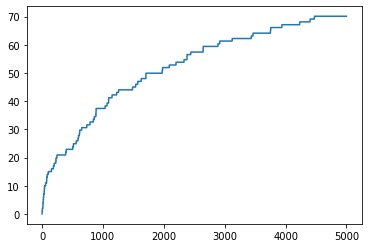

In [797]:
plt.plot(playerX.policy_trainer.scores)
plt.show()

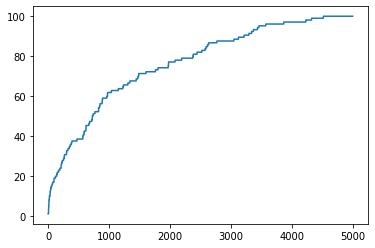

In [798]:
plt.plot(playerO.policy_trainer.scores)
plt.show()

### Trained Q-values for Player X


In [799]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [800]:
playerX.policy_trainer.num_times_states_seen

{'[[ 0  0 -1]\n [ 0  1 -1]\n [ 0  0  0]]': array([[1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]), '[[ 0  0 -1]\n [ 0  1 -1]\n [ 0 -1  0]]': array([[1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]), '[[ 0  0 -1]\n [ 0  1 -1]\n [ 0 -1  1]]': [array([0, 0])], '[[ 0  0 -1]\n [ 0  1 -1]\n [ 1 -1  0]]': array([[1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]), '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  0  0]]': array([[1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]), '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  0  1]]': array([[1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]), '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  1  0]]': array([[1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]), '[[ 0  0 -1]\n [ 0  1 -1]\n [-1 -1  1]]': [array([0, 0])], '[[ 0  0 -1]\n [ 1  1 -1]\n [ 0 -1  0]]': array

In [801]:
playerX.policy_trainer.Q

{'[[ 0  0 -1]\n [ 0  1 -1]\n [ 0  0  0]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 0 -1  0]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.90]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 0 -1  1]]': array([1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 1 -1  0]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  0  0]]': array([0.90, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.90, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  0  1]]': array([1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  1  0]]': array([0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [-1 -1  1]]': array([1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 1  1 -1]\n [ 0 -1  0]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 1  1 -1]\n [-1  0  0]]': arr

### Trained Q-values for Player O

In [802]:
playerO.policy_trainer.Q

{'[[ 0  0 -1]\n [ 0  1 -1]\n [ 0  0  0]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 0  0  1]]': array([0.90, 0.90, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 0  1  0]]': array([0.90, 0.90, 0.00, 0.00, 0.00, 0.00, 0.90, 0.00, 1.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 0 -1  1]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 1  0  0]]': array([0.90, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 1 -1  0]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [ 1 -1  1]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  0  1]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  1  0]]': array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00]),
 '[[ 0  0 -1]\n [ 0  1 -1]\n [-1  1  1]]': arr

# Testing Section
Test the functions 

In [803]:
board=Board()
print(board.checkWinner())

board.state = np.array(((-1,-1,-1), (0,0,0), (0,0,0)))
print(board.checkWinner())
print(board.getStateHash())
pos = board.getAvailablePos()
print("getAvailablePos\n", pos)
print("checkGameEnded\n", board.checkGameEnded())


list1 = board.getAvailablePos()
print("shape\n",list1.shape[0])
ch1= np.random.choice(list1.shape[0])
print("random.choice\n",ch1)
print("random action\n", list1[ch1])

board.state = np.array(((-1,0,0), (0,1,0), (0,0,-1)))
print(board.getStateHash())

board.state = np.array(((-1,1,1), (1,1,1), (1,-1,-1)))
print(board.checkGameEnded())





0
-1
[[-1 -1 -1]
 [ 0  0  0]
 [ 0  0  0]]
getAvailablePos
 [[1 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]]
checkGameEnded
 True
shape
 6
random.choice
 0
random action
 [1 0]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
True
